In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.style as style
from tqdm import tqdm 
tqdm.pandas()
plt.rcParams.update({'axes.labelsize':16})
plt.rcParams.update({'axes.titlesize':16})
plt.rcParams.update({'legend.fontsize':16})
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 4
style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
import datetime

In [8]:
df_2020 = pd.read_csv('../data/richmond_apparatus_data.csv')
df_2019 = pd.read_csv('../data/richmond_apparatus_data_2019.csv')

In [9]:
df = pd.concat([df_2019, df_2020]).reset_index()

In [10]:
df['year'] = pd.DatetimeIndex(pd.to_datetime(df['apparatus_data.unit_status.enroute.timestamp'], utc=True)).year
df['month'] = pd.DatetimeIndex(pd.to_datetime(df['apparatus_data.unit_status.enroute.timestamp'], utc=True)).month
df['week'] = pd.DatetimeIndex(pd.to_datetime(df['apparatus_data.unit_status.enroute.timestamp'], utc=True)).week
df['apparatus_data.unit_status.enroute.timestamp'] = pd.to_datetime(df['apparatus_data.unit_status.enroute.timestamp'])
df['apparatus_data.unit_status.arrived.timestamp'] = pd.to_datetime(df['apparatus_data.unit_status.arrived.timestamp'])

In [11]:
df = df.dropna(subset=['apparatus_data.unit_status.arrived.timestamp'])

In [12]:
df = df[df['apparatus_data.unit_status.enroute.timestamp'] < pd.to_datetime(datetime.date(2021, 3, 1), utc=True)]

In [36]:
np.unique(df['address.location.census.census_2010.census_id'].dropna())

array([5.10411001e+14, 5.10411001e+14, 5.10411001e+14, ...,
       5.17600711e+14, 5.17600711e+14, 5.17600711e+14])

In [121]:
 df['address.location.social_vulnerability_2016.general.fips'] =  df['address.location.social_vulnerability_2016.general.fips'].astype(str)
df['fips_county'] = df['address.location.social_vulnerability_2016.general.fips'].apply(lambda x: x[:5])
county_number = df['fips_county'].value_counts(ascending=False).idxmax()
county_number


'51760'

In [122]:
 df['address.location.social_vulnerability_2016.general.fips'].value_counts(ascending=False).idxmax()

'51760030500.0'

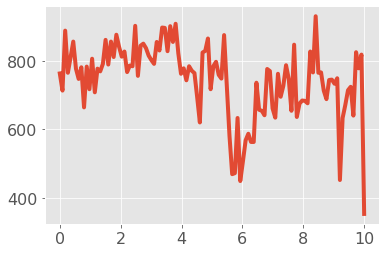

In [13]:
grouped_df = df.groupby(['year','week']).size().to_frame().reset_index()
grouped_df = grouped_df.rename(columns={grouped_df.columns[-1]: 'incident_count'})
plt.plot(np.linspace(0,10,len(grouped_df)), grouped_df['incident_count'])

In [14]:
from dateutil.relativedelta import relativedelta
def get_date(df_row):
    date = datetime.date(int(df_row['year']), 1, 1) + relativedelta(weeks=+df_row['week']-1)
    return date
    

In [15]:
grouped_df['effective_date'] = pd.to_datetime([get_date(grouped_df.iloc[i]) for i in range(len(grouped_df))])

# Pear sandbox

In [16]:
pear_df = df.copy()
pear_df['description.event_opened'] = pd.to_datetime(pear_df['description.event_opened'])
pear_df['date'] = pear_df['description.event_opened'].progress_apply(lambda x: x.strftime('%Y-%m-%d'))

daily_counts = pear_df.groupby('date').size().reset_index(name='count')

# df['date'] = df['']

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84884/84884 [00:00<00:00, 316250.10it/s]


In [17]:
daily_counts['sum_of_last_7_days'] = daily_counts.rolling(window=7).sum()
daily_counts['day_of_week'] = daily_counts['date'].progress_apply(lambda x: pd.to_datetime(x).day_name())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 791/791 [00:00<00:00, 19674.17it/s]


In [18]:
df_2020_google = pd.read_csv('../data/google_data/2020_US_Region_Mobility_Report.csv')
#df_2019_google = pd.read_csv('../data/google_data/2019_US_Region_Mobility_Report.csv')
#df = pd.concat([df_2019_google, df_2020_google]).reset_index()

In [79]:
np.sum()

321

In [89]:
df_virginia = df_2020_google[df_2020_google['sub_region_1'] == 'Virginia']
df_richmond = df_virginia[df_virginia['sub_region_2'] == 'Richmond County']
df_richmond = df_virginia.loc[df_virginia['census_fips_code'] == int(county_number)]

mobility_df = df_richmond[['date', 'workplaces_percent_change_from_baseline']]
mobility_df['avg_last_7_days'] = mobility_df['workplaces_percent_change_from_baseline'].rolling(window=7, min_periods=1).mean(skipna=True)
mobility_df['day_of_week'] = mobility_df['date'].progress_apply(lambda x: pd.to_datetime(x).day_name())


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 16929.32it/s]


In [98]:
np.unique(df_richmond['census_fips_code'])

array([51760.])

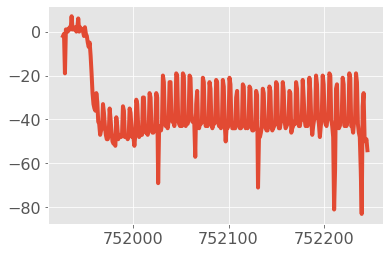

In [104]:
plt.plot(df_richmond['workplaces_percent_change_from_baseline'])

In [105]:
first_day_of_week = 'Monday'
weekly_incident_counts = daily_counts[daily_counts['day_of_week']==first_day_of_week]
weekly_incident_counts['date'] = pd.to_datetime(weekly_incident_counts['date'])
weekly_mobility = mobility_df[mobility_df['day_of_week']==first_day_of_week]
weekly_mobility['date'] = pd.to_datetime(weekly_mobility['date'])

In [110]:
mobility_df.groupby('day_of_week').mean()

,workplaces_percent_change_from_baseline,avg_last_7_days
day_of_week,,
Friday,-40.288889,-35.387302
Monday,-39.217391,-35.050725
Saturday,-22.673913,-34.760870
Sunday,-24.478261,-34.833851
Thursday,-41.391304,-35.445135
Tuesday,-40.347826,-35.163820
Wednesday,-40.521739,-35.291925


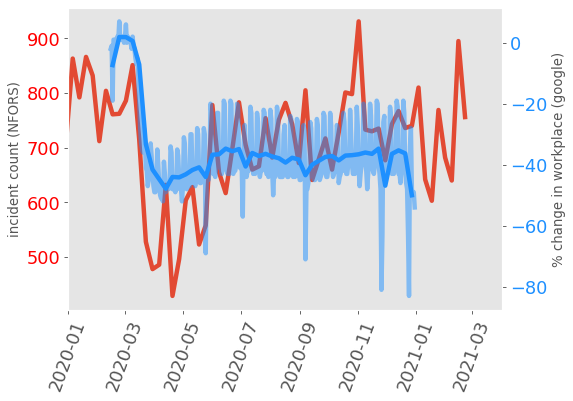

In [109]:
plt.figure(figsize=(7, 5), dpi=80)
ax1 = plt.subplot()
l1, = ax1.plot(weekly_incident_counts['date'], weekly_incident_counts['sum_of_last_7_days'])
ax1.tick_params(axis='y', labelcolor='red')
ax1.tick_params(axis='x', rotation=70)
ax1.set_ylabel('incident count (NFORS)')
ax2 = ax1.twinx()
l2, = ax2.plot(weekly_mobility['date'], weekly_mobility['avg_last_7_days'], color='dodgerblue')
ax2.tick_params(axis='y', labelcolor='dodgerblue')
ax2.plot(pd.to_datetime(df_richmond['date']) , df_richmond['workplaces_percent_change_from_baseline'], color='dodgerblue',alpha=.5)
ax2.set_ylabel('% change in workplace (google)')
ax1.grid(False)
ax2.grid(False)
plt.xlim(left=pd.to_datetime('2020-01-01'));


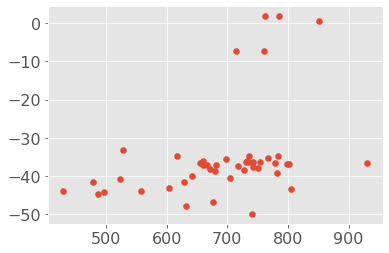

In [95]:
df_new = pd.merge(weekly_mobility, weekly_incident_counts, how='inner', on='date')
plt.scatter(df_new['sum_of_last_7_days'], df_new['avg_last_7_days'])

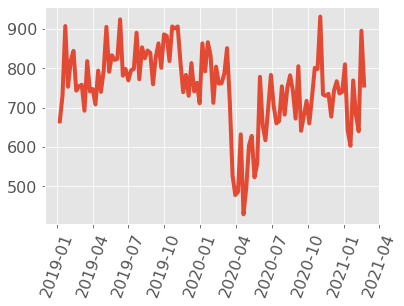

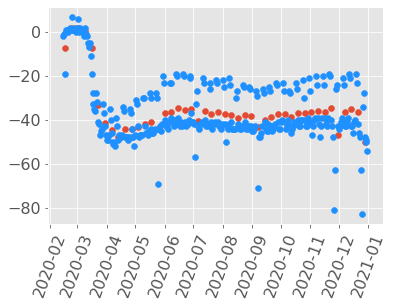

In [96]:
plt.plot(weekly_incident_counts['date'], weekly_incident_counts['sum_of_last_7_days'])
plt.xticks(rotation=70)
plt.figure()
plt.scatter(weekly_mobility['date'], weekly_mobility['avg_last_7_days'])
plt.xticks(rotation=70)
plt.scatter(pd.to_datetime(df_richmond['date']) , df_richmond['workplaces_percent_change_from_baseline'], color='dodgerblue')



In [ ]:
grouped_df

In [ ]:
plt.plot(grouped_df['effective_date'], grouped_df['incident_count'])
plt.xticks(rotation=70);

In [ ]:
import datetime
d = '2013-W53'
r = datetime.datetime.strptime(d + '-1', '%G-W%V-%u')
print(r)

In [ ]:
grouped_df['date'] = pd.to_datetime(grouped_df[['year','month']].assign(day=15))

In [ ]:
baseline_per_month =  grouped_df.groupby('year').get_group(2019).sort_values('month')[['month','incident_count']]
baseline_per_month = baseline_per_month.rename(columns={'incident_count': 'baseline_count'})


In [ ]:
merged_df = pd.merge(baseline_per_month, grouped_df, how='inner', on=['month'])

In [ ]:
merged_df = merged_df.sort_values('date')

In [ ]:
merged_df['change_from_baseline'] = (merged_df['incident_count'] -  merged_df['baseline_count'])/merged_df['baseline_count'] * 100

In [ ]:
plt.figure(figsize=(7, 5), dpi=80)
plt.plot(merged_df['date'], merged_df['incident_count'])
plt.xticks(grouped_df['date'][::5]);

In [ ]:
df_2020_google = pd.read_csv('../data/google_data/2020_US_Region_Mobility_Report.csv')
#df_2019_google = pd.read_csv('../data/google_data/2019_US_Region_Mobility_Report.csv')
#df = pd.concat([df_2019_google, df_2020_google]).reset_index()

In [ ]:
df_virginia = df_2020_google[df_2020_google['sub_region_1'] == 'Virginia']
df_richmond = df_virginia[df_virginia['sub_region_2'] == 'Richmond County']

In [ ]:
df_richmond['date'] = pd.to_datetime(df_richmond['date'])
df_richmond['month'] =  pd.DatetimeIndex(df_richmond['date']).month
df_richmond['year'] =  pd.DatetimeIndex(df_richmond['date']).year
df_richmond_google_grouped = df_richmond.groupby(['year','month']).mean().reset_index()
df_richmond_google_grouped['date'] = pd.to_datetime(df_richmond_google_grouped[['year','month']].assign(day=15))

In [ ]:
plt.figure(figsize=(7, 5), dpi=80)
ax1 = plt.subplot()
l1, = ax1.plot(grouped_df['date'], grouped_df['incident_count'], color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.tick_params(axis='x', rotation=70)
ax1.set_ylabel('incident count (NFORS)')
ax2 = ax1.twinx()
l2, = ax2.plot(df_richmond['date'] , df_richmond['workplaces_percent_change_from_baseline'], color='dodgerblue')
ax2.tick_params(axis='y', labelcolor='dodgerblue')
ax2.set_ylabel('% change in workplace (google)')
ax1.grid(False)
ax2.grid(False)



In [ ]:
plt.figure(figsize=(7, 5), dpi=80)
plt.plot(merged_df['date'], merged_df['change_from_baseline'], color='red', label='incident count (NFORS)')
plt.plot(df_richmond_google_grouped['date'] , df_richmond_google_grouped['workplaces_percent_change_from_baseline'], color='dodgerblue', label='workplace mobility (Google)')
plt.xticks(rotation=70)
plt.ylabel('% change compared to baseline')
plt.legend()
plt.grid(False)

In [ ]:
plt.hist(grouped_df['baseline_incident_change'], bins=20, density=True);

In [ ]:
plt.hist(grouped_df['incident_count'], bins=20, density=True);

In [ ]:
merged_df = pd.merge(df_richmond_google_grouped, grouped_df, how='inner', on=['date'])
merged_df = merged_df.sort_values('workplaces_percent_change_from_baseline')
merged_df = merged_df.dropna(subset=['incident_count', 'workplaces_percent_change_from_baseline'])

In [ ]:
X_matrix = np.ones((len(merged_df),2))
X_matrix[:,1] = merged_df['workplaces_percent_change_from_baseline'].to_numpy()
Y_matrix = merged_df['incident_count'].to_numpy()
theta = np.ones(2)

In [ ]:
def log_likelihood(theta):        
    LL = (Y_matrix*(X_matrix@theta) - np.exp((X_matrix@theta))).sum()
    return -LL

In [ ]:
from scipy.optimize import minimize
theta_ML = minimize(log_likelihood, theta, method='Nelder-Mead').x
Lambda = np.exp(X_matrix@theta_ML)

In [ ]:
from scipy.stats import poisson

In [ ]:
lower = poisson(mu = Lambda).ppf(0.025)
upper = poisson(mu = Lambda).ppf(1-0.025)

In [ ]:
plt.plot(X_matrix[:,1], X_matrix@theta_ML, alpha=.5)
plt.fill_between(X_matrix[:,1], np.log(lower), np.log(upper), alpha=0.5)
plt.scatter(X_matrix[:,1], np.log(Y_matrix),color='black')
plt.xlabel('mobility')
plt.ylabel('log(incident_count)');

In [ ]:
plt.plot(X_matrix[:,1], np.exp(X_matrix@theta_ML), alpha=.5)
plt.fill_between(X_matrix[:,1], lower, upper, alpha=0.5)
plt.scatter(X_matrix[:,1], Y_matrix, color='black')
plt.xlabel('mobility')
plt.ylabel('incident_count');

In [ ]:
y_pred = np.exp(X_matrix@theta_ML)
plt.scatter(y_pred, Y_matrix)
lower = poisson.ppf(q=.025, mu=y_pred)
upper = poisson.ppf(q=.975, mu=y_pred)
plt.fill_between(y_pred, lower, upper, alpha=.5)
plt.ylabel('actual')
plt.xlabel('pred');

In [ ]:
#check it gives the same
from sklearn import linear_model
clf = linear_model.PoissonRegressor()
clf.fit(X_matrix[:,1].reshape(-1,1), Y_matrix.reshape(-1,1))
clf.coef_

In [ ]:
clf.intercept_

In [ ]:
from statsmodels.discrete.discrete_model import NegativeBinomial

In [ ]:
Y_matrix.reshape(-1,1).shape
#X_matrix.shape

In [ ]:
res = NegativeBinomial(Y_matrix, X_matrix).fit()

In [ ]:
theta = np.array([res.params[0], res.params[1]])
theta

In [ ]:
plt.scatter(X_matrix[:,1], Y_matrix)
plt.plot(X_matrix[:,1], np.exp(X_matrix@theta))

In [ ]:
mu = np.exp(X_matrix@theta)
var = mu + mu**2 * res.params[2]

In [ ]:
from scipy.stats import nbinom

In [ ]:
p = mu/var
n = mu**2/(var-mu)

In [ ]:
lower = nbinom(p=p,n=n).ppf(0.025)
upper = nbinom(p=p,n=n).ppf(1-0.025)

In [ ]:
plt.scatter(X_matrix[:,1], Y_matrix)
plt.plot(X_matrix[:,1], np.exp(X_matrix@theta))
plt.fill_between(X_matrix[:,1], lower, upper, alpha=.5)
#Much better!!